In [1]:
!pip install geocoder

In [2]:
!pip install geopy

In [3]:
!pip install twilio

In [4]:
!pip install scikit-image

In [5]:
!pip install skimage

  Using cached skimage-0.0.tar.gz (757 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [3 lines of output]
  
  *** Please install the `scikit-image` package (instead of `skimage`) ***
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [6]:
import os
import cv2     # for capturing videos
import math 
import geocoder
import requests
%matplotlib inline
import pandas as pd
from twilio.rest import Client
from geopy.geocoders import Nominatim
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt 
from skimage.transform import resize   # for resizing images

In [7]:
count = 0
videoFile = "Accidents.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


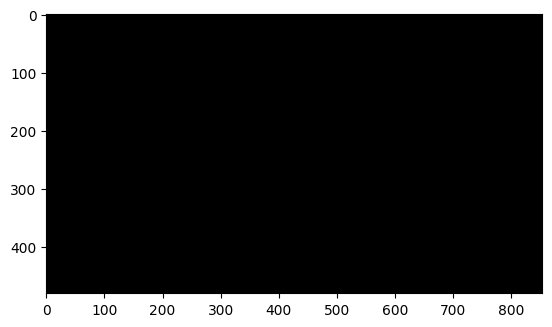

In [8]:
img = plt.imread('0.jpg')   # reading image using its name
plt.imshow(img)

In [9]:
data1 = pd.read_csv('test2.csv')
data1.head()

,Image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg


In [10]:
data = pd.read_csv('mapping.csv')     # reading the csv file
data.head()

,Image_ID,Class
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [11]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [12]:
y = data.Class
dummy_y = to_categorical(y)

In [13]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [14]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X,data_format=None)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

In [16]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [18]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


((155, 7, 7, 512), (67, 7, 7, 512))

In [19]:
X_train = X_train.reshape(155, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(67, 7*7*512)

In [20]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [21]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,693,186 (98.01 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.6286 - loss: 0.7080 - val_accuracy: 0.6418 - val_loss: 0.7977
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.7754 - loss: 0.3940 - val_accuracy: 0.7612 - val_loss: 0.9460
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.9143 - loss: 0.2439 - val_accuracy: 0.6716 - val_loss: 0.8531
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9663 - loss: 0.1177 - val_accuracy: 0.7313 - val_loss: 0.8963
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9792 - loss: 0.1109 - val_accuracy: 0.7612 - val_loss: 0.8555
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.9818 - loss: 0.0754 - val_accuracy: 0.7463 - val_loss: 0.8340
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 1.0000 - loss: 0.0307 - val_accuracy: 0.7612 - val_loss: 0.8928
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9870 - loss: 0.0409 - val_accuracy: 0.7463 - v

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
count = 0
videoFile = "Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [27]:
test2 = pd.read_csv('test2.csv')

In [28]:
test_image = []
for img_name in test2.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [29]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [30]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)
test_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(9, 7, 7, 512)

In [31]:
test_image = test_image.reshape(9, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [32]:
predictions = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [33]:
print(predictions)

[[4.0026198e-06 9.9999595e-01]
 [1.9424057e-04 9.9980575e-01]
 [2.3376856e-03 9.9766231e-01]
 [1.0748646e-03 9.9892515e-01]
 [3.2019736e-03 9.9679810e-01]
 [5.8391184e-01 4.1608813e-01]
 [8.1926543e-01 1.8073457e-01]
 [6.7301643e-01 3.2698357e-01]
 [8.8978750e-01 1.1021243e-01]]


In [34]:
for i in range (0,9):
    if predictions[i][0]<predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")
    

No Accident
No Accident
No Accident
No Accident
No Accident
Accident
Accident
Accident
Accident


In [46]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid = "AC6659f59d07ab29d9db484e4b7d4635f3"
auth_token = "b289986f6b02f5edc5625b40dc51e3f7"
client = Client(account_sid, auth_token)

In [47]:
cap = cv2.VideoCapture('Accident-1.mp4')
i=0
flag=0
while(True):
    ret,frame=cap.read()
    if ret==True:
        if predictions[int(i/15)%9][0]<predictions[int(i/15)%9][1]:
            predict="No Accident"
        else:
            predict="Accident"
            flag=1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,
                predict,
                (50, 50),
                font, 1,
                (0, 255, 255),
                3,
                cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i=i+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
if flag==1:
    client.messages.create(
                 body="Accident detected in "+locname.address,
                 from_= 12728923962,
                 to= 918142653786)

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()
